```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%%capture
!pip install parameter-sherpa

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sherpa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logger.info("IS_CRITICAL")

torch.__version__

'1.3.1'

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
path = "drive/My Drive/AML/"
#path = ""

df = pd.read_csv(path + "pmsm_temperature_data.csv")

In [0]:
df_sep = [df[df
          .profile_id==profile]
          .drop(['profile_id','torque','stator_yoke',
                 'stator_tooth','stator_winding'],axis=1)
          .reset_index(drop=True) for profile in df.profile_id.unique()]

In [0]:
def outputSize(in_size, kernel_size, stride, padding):
  output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
  return(output)

class CNN_Net_2(nn.Module):
    def __init__(self, batch, in_c, out, 
                 filtro1, filtro2,
                 num_ser, 
                 neuroni1, neuroni2,
                 kernel1, kernel2, kernel3, kernel4, 
                 #padding1, padding2, padding3, padding4, 
                 stride1, stride2, stride3, stride4):
        super(CNN_Net_2, self).__init__()
        self.batch_size = 1
        self.in_c = in_c
        l0 = num_ser
        l1 = outputSize(l0,kernel1,stride1,0)
        l2 = outputSize(l1,kernel2,stride2,0)
        l3 = outputSize(l2,kernel3,stride3,0)
        l4 = outputSize(l3,kernel4,stride4,0)
        #print(l4)

        self.conv1 = nn.Conv1d(in_channels= in_c, 
                               out_channels= filtro1, 
                               kernel_size= kernel1,
                               stride= stride1,
                               padding=0)    
        self.pool1 = nn.MaxPool1d(kernel2,stride=stride2,padding=0) 
        self.conv2 = nn.Conv1d(filtro1,filtro2,kernel3,stride=stride3,padding=0)
        self.pool2 = nn.MaxPool1d(kernel4,stride=stride4,padding=0)
        self.fc1 = nn.Linear(filtro2*l4, neuroni1)
        self.fc2 = nn.Linear(neuroni1, neuroni2)
        self.fc3 = nn.Linear(neuroni2, out)

    def forward(self, x):
        batch_size, _, _ = x.shape
        x =  self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(batch_size, self.num_flat_features(x))
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return  self.fc3(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:       # Get the products
            num_features *= s
        return num_features

In [8]:
l0 = 8
l1 = outputSize(l0,2,2,0)
l2 = outputSize(l1,2,2,0)
l3 = outputSize(l2,2,2,0)
l4 = outputSize(l3,2,2,0)
print(l1,l2,l3,l4)

4 2 1 1


In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7]

In [0]:
def dataloader(data, length, shuffle=True, out=1):
    while True:
    # genera una lista di (i_serie, i_obs)
        tuples = [[(df_i, i) for i, x in enumerate(data[df_i]) if i >= length + out]
                  for df_i, _ in enumerate(data)]
        tuples = sum(tuples, [])  # flattenizza
        # shuffle
        if shuffle:
            np.random.shuffle(tuples)
        # yielda le osservazioni
        for df_i, i in tuples:
            X_lagged = data[df_i][(i - length - out):(i - out), FEATURES + TARGET]
            y = data[df_i][(i-out):(i), TARGET]
            yield X_lagged, y

In [0]:
train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'stator_yoke','stator_tooth',
                                                                                  'stator_winding'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'stator_yoke','stator_tooth',
                                                                                  'stator_winding'], 
                                                                                 axis=1).max()

In [0]:
df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [0]:
parameters = [sherpa.Continuous('lr',[0.00005,0.05]),
              sherpa.Discrete('filtro1',[10,50]),
              sherpa.Discrete('filtro2',[10,50]),
              sherpa.Discrete('neuroni1',[10,100]),
              sherpa.Discrete('neuroni2',[10,100]),
              sherpa.Discrete('kernel1',[1,2]),
              sherpa.Discrete('kernel2',[1,2]),
              sherpa.Discrete('kernel3',[1,2]),
              sherpa.Discrete('kernel4',[1,2]),
              sherpa.Discrete('stride1',[1,2]),
              sherpa.Discrete('stride2',[1,2]),
              sherpa.Discrete('stride3',[1,2]),
              sherpa.Discrete('stride4',[1,2]),
              sherpa.Choice('batch_size',[256, 512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

ID 1 New Challanger with MSE on val: 0.03290227814111009 and confs: {'lr': 0.04942303882532329, 'filtro1': 22, 'filtro2': 26, 'neuroni1': 64, 'neuroni2': 19, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride1': 1, 'stride2': 1, 'stride3': 1, 'stride4': 1, 'batch_size': 512}
ID 3 New Challanger with MSE on val: 4.5634416051379475e-05 and confs: {'lr': 0.03965470659639078, 'filtro1': 43, 'filtro2': 33, 'neuroni1': 40, 'neuroni2': 46, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride1': 1, 'stride2': 1, 'stride3': 1, 'stride4': 1, 'batch_size': 512}
ID 5 New Challanger with MSE on val: 1.1075588447106353e-05 and confs: {'lr': 0.004271815386114013, 'filtro1': 43, 'filtro2': 36, 'neuroni1': 84, 'neuroni2': 61, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride1': 1, 'stride2': 1, 'stride3': 1, 'stride4': 1, 'batch_size': 2048}
ID 12 New Challanger with MSE on val: 8.334540045740427e-06 and confs: {'lr': 0.01249204840178357, 'filtro1': 39, 'filtro2': 

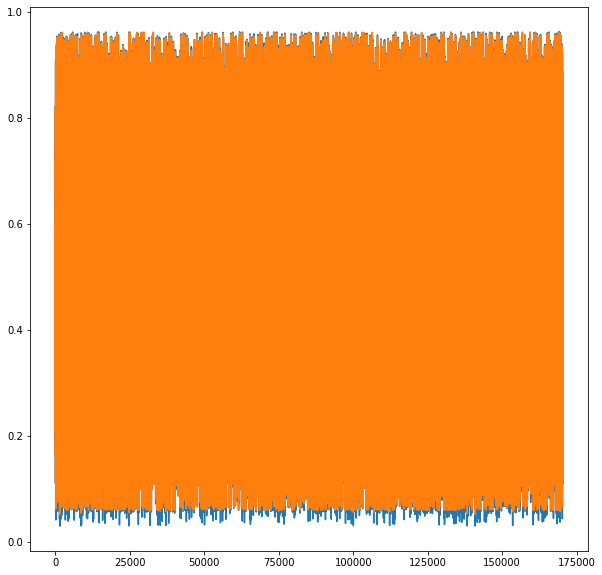

In [0]:
best_score = 99999
feature    = 8

for trial in study:

    look_back  = 60 

    lstm = CNN_Net_2(batch=int(trial.parameters["batch_size"]),
                     in_c=look_back,
                     out = 1,
                     num_ser = 8,
                     filtro1=int(trial.parameters["filtro1"]),
                     filtro2=int(trial.parameters["filtro2"]),
                     neuroni1=int(trial.parameters["neuroni1"]),
                     neuroni2=int(trial.parameters["neuroni2"]),
                     kernel1=int(trial.parameters["kernel1"]),
                     kernel2=int(trial.parameters["kernel2"]),
                     kernel3=int(trial.parameters["kernel3"]),
                     kernel4=int(trial.parameters["kernel4"]),
                     stride1=int(trial.parameters["stride1"]),
                     stride2=int(trial.parameters["stride2"]),
                     stride3=int(trial.parameters["stride3"]),
                     stride4=int(trial.parameters["stride4"])
                     ).to(device)
                     
    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, look_back, 8)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break

    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back, 8)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_cnn")
        print("ID",trial.id,"New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN.csv")
    y_test = np.array(y_test).reshape(-1)

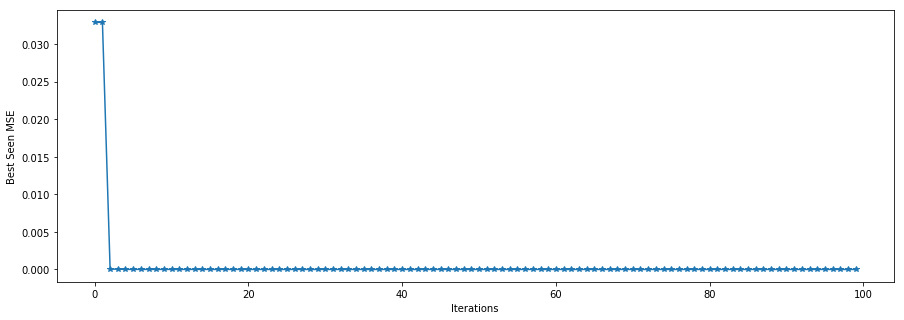

In [0]:
best_model = torch.load(path + "models/best_model_cnn")
results = pd.read_csv(path + "results/AutoML_CNN.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

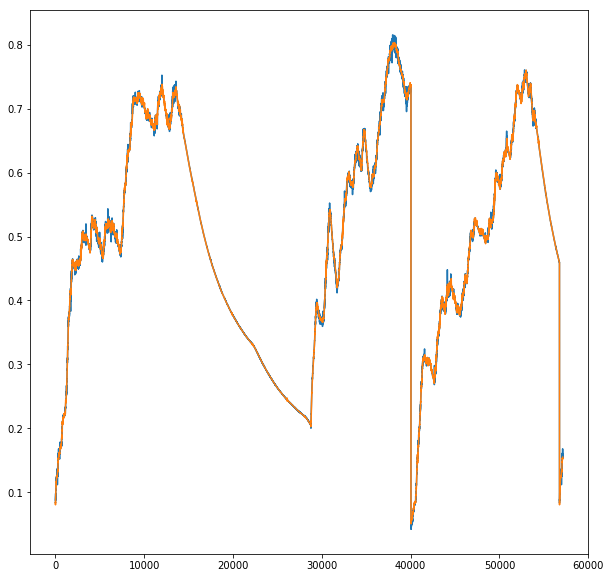

In [0]:
look_back  = 60

test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
size = np.sum(df.shape[0] for df in df_test)

batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, look_back, 8)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())


y_test = np.array(y_test).reshape(-1)

plt.figure(figsize=(10,10))
plt.plot(y_test[:])
plt.plot(y_pred_all[:])

plt.show()

# New Loss

In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque'], 
                                                                               axis=1).max()

df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]


FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7, 8, 9, 10]

In [0]:
def new_loss(w1=1, w2=1):
    "w1 is the weight for lower temperature and w2 for the upper So w1 <= w2"
    def high_low_loss(output, target):
        weights = w1 + (w2 - w1)*F.relu(target - 0.5)
        return torch.mean(weights*((output - target)**2))
    
    return high_low_loss

In [0]:
parameters = [sherpa.Continuous('lr',[0.00005,0.05]),
              sherpa.Discrete('filtro1',[10,50]),
              sherpa.Discrete('filtro2',[10,50]),
              sherpa.Discrete('neuroni1',[10,100]),
              sherpa.Discrete('neuroni2',[10,100]),
              sherpa.Discrete('kernel1',[1,2]),
              sherpa.Discrete('kernel2',[1,2]),
              sherpa.Discrete('kernel3',[1,2]),
              sherpa.Discrete('kernel4',[1,2]),
              sherpa.Discrete('stride1',[1,2]),
              sherpa.Discrete('stride3',[1,2]),
              sherpa.Choice('batch_size',[256, 512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [24]:
best_score = 99999
feature    = 11

for trial in study:

    look_back  = 60 

    lstm = CNN_Net_2(batch=int(trial.parameters["batch_size"]),
                     in_c = look_back,
                     out = 4,
                     num_ser = 11,
                     filtro1=int(trial.parameters["filtro1"]),
                     filtro2=int(trial.parameters["filtro2"]),
                     neuroni1=int(trial.parameters["neuroni1"]),
                     neuroni2=int(trial.parameters["neuroni2"]),
                     kernel1=int(trial.parameters["kernel1"]),
                     kernel2=int(trial.parameters["kernel2"]),
                     kernel3=int(trial.parameters["kernel3"]),
                     kernel4=int(trial.parameters["kernel4"]),
                     stride1=int(trial.parameters["stride1"]),
                     stride2=1,
                     stride3=int(trial.parameters["stride3"]),
                     stride4=1).to(device)
                     
    losses = []
    criterion = new_loss(1,3)
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, look_back, 11)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(-1), y_batch.view(-1))  
            
            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break

    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back, 11)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    #score = np.mean((y_test - y_pred_all)**2) #MSE
    score = np.mean(criterion(torch.tensor(y_pred_all), 
                              torch.tensor(y_test)).item())
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_cnn_newLoss")
        print("ID:",trial.id,"New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN_newLoss.csv")

ID: 1 New Challanger with MSE on val: 0.00019494812517724738 and confs: {'lr': 0.009810163115928836, 'filtro1': 19, 'filtro2': 41, 'neuroni1': 53, 'neuroni2': 37, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride1': 1, 'stride3': 1, 'batch_size': 512}
ID: 2 New Challanger with MSE on val: 8.694694169293983e-05 and confs: {'lr': 0.010659511659255903, 'filtro1': 35, 'filtro2': 25, 'neuroni1': 12, 'neuroni2': 22, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride1': 1, 'stride3': 1, 'batch_size': 1024}
ID: 5 New Challanger with MSE on val: 3.900495595899172e-05 and confs: {'lr': 0.017434517538115007, 'filtro1': 47, 'filtro2': 17, 'neuroni1': 63, 'neuroni2': 44, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride1': 1, 'stride3': 1, 'batch_size': 256}
ID: 29 New Challanger with MSE on val: 1.9507624221258052e-05 and confs: {'lr': 0.0013920633106409342, 'filtro1': 35.0, 'filtro2': 29.0, 'neuroni1': 74.0, 'neuroni2': 77.0, 'kernel1': 1.0, 'kernel2': 1.0

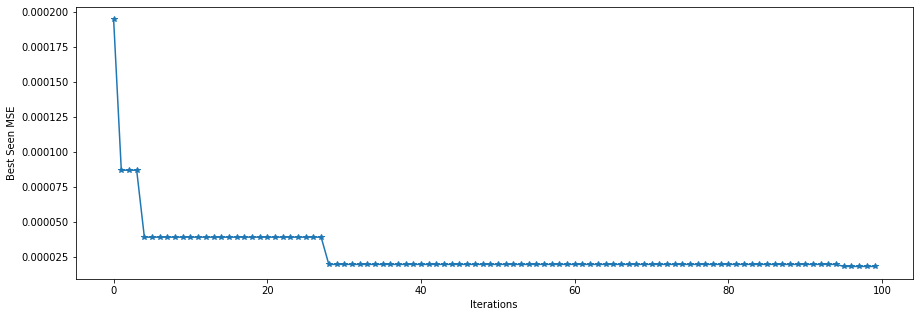

In [26]:
best_model = torch.load(path + "models/best_model_cnn_newLoss")
results = pd.read_csv(path + "results/AutoML_CNN_newLoss.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back  = 60

test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
size = np.sum(df.shape[0] for df in df_test)
batch_size = 510

y_test = []
y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break
    inpt = np.array(X_test).reshape(-1, look_back, 11)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)

    y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

y_pred_all = y_pred_all.reshape(-1,4)
y_test = np.array(y_test).reshape(-1,4)

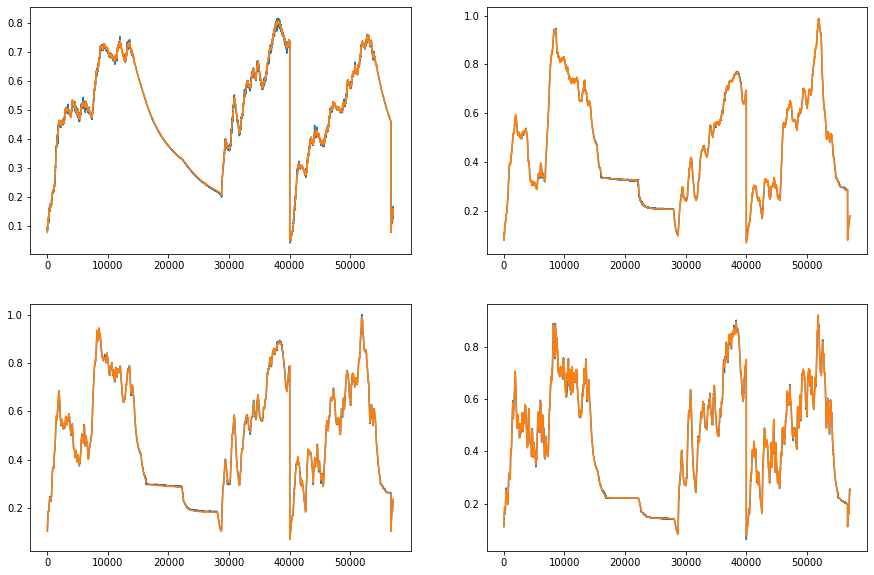

In [30]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.plot(y_test[:,0])
plt.plot(y_pred_all[:,0])

plt.subplot(222)
plt.plot(y_test[:,1])
plt.plot(y_pred_all[:,1])

plt.subplot(223)
plt.plot(y_test[:,2])
plt.plot(y_pred_all[:,2])

plt.subplot(224)
plt.plot(y_test[:,3])
plt.plot(y_pred_all[:,3])
plt.show()

In [31]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test)))

0.007148206952592805

# STATOR

In [0]:
df_sep = [df[df.profile_id==profile].drop(['profile_id','torque','pm'], 
                                          axis=1).reset_index(drop=True) for profile in df.profile_id.unique()]

In [0]:
FEATURES = [0, 1, 2, 3, 4, 5, 6]
TARGET = [7,8,9]

In [0]:
train_min = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'pm'], 
                                                                                 axis=1).min()
train_max = df[~df.profile_id.isin([4, 8, 16, 24, 32, 40, 48, 51, 35, 42])].drop(['profile_id','torque',
                                                                                 'pm'], 
                                                                                 axis=1).max()

In [0]:
df_train = [(df_sep[i] - train_min)/(train_max - train_min)\
            for i in list(range(0,52)) if i not in [4, 8, 16, 24, 32, 
                                                    40, 48, 51, #val
                                                    35, 42]] #test

df_val = [(df_sep[i] - train_min)/(train_max - train_min)\
          for i in [4, 8, 16, 24, 32, 40, 48, 51]]

df_test = [(df_sep[i] - train_min)/(train_max - train_min) for i in [35, 42]]

In [0]:
parameters = [sherpa.Continuous('lr',[0.00005,0.05]),
              sherpa.Discrete('filtro1',[10,500]),
              sherpa.Discrete('filtro2',[10,500]),
              sherpa.Discrete('neuroni1',[10,200]),
              sherpa.Discrete('neuroni2',[10,200]),
              sherpa.Discrete('kernel1',[1,2]),
              sherpa.Discrete('kernel2',[1,2]),
              sherpa.Discrete('kernel3',[1,2]),
              sherpa.Discrete('kernel4',[1,2]),
              sherpa.Discrete('stride1',[1,2]),
              sherpa.Discrete('stride3',[1,2]),
              sherpa.Choice('batch_size',[256, 512, 1024, 2048])]

alg = sherpa.algorithms.bayesian_optimization.GPyOpt(max_concurrent=1,
                                         model_type='GP',
                                         acquisition_type='EI',
                                         max_num_trials=100)

study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True,
                     disable_dashboard=True)

In [0]:
look_back = 60
best_score = 99999
feature = 10

for trial in study:

    lstm = CNN_Net_2(batch=int(trial.parameters["batch_size"]),
                     in_c = 60,
                     out = 3,
                     num_ser = 10,
                     filtro1=int(trial.parameters["filtro1"]),
                     filtro2=int(trial.parameters["filtro2"]),
                     neuroni1=int(trial.parameters["neuroni1"]),
                     neuroni2=int(trial.parameters["neuroni2"]),
                     kernel1=int(trial.parameters["kernel1"]),
                     kernel2=int(trial.parameters["kernel2"]),
                     kernel3=int(trial.parameters["kernel3"]),
                     kernel4=int(trial.parameters["kernel4"]),
                     stride1=int(trial.parameters["stride1"]),
                     stride2=1,
                     stride3=int(trial.parameters["stride3"]),
                     stride4=1).to(device)
                         
    losses = []
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=trial.parameters["lr"])

    batch_size = int(trial.parameters["batch_size"])

    df_length = np.sum([x.shape[0] for x in df_train])

    gen = dataloader([df.values for df in df_train], look_back)
    progress_bar = range(0, df_length, batch_size)

    lstm.train()
    for b in progress_bar:
        X_train = []
        y_train = []
        for i in range(batch_size):
            try:
                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
            except StopIteration:
                #in case the datagen ends, recreate a new a one and continue
                #it should not happen though since the the datagen
                #should be infinite (theorically), it's more of a precaution
                gen = dataloader([df.values for df in df_train], look_back)

                X,y = next(gen)
                X_train.append(X)
                y_train.append(y)
        
        inpt = np.array(X_train).reshape(-1, look_back, 10)
        target = np.array(y_train)    
        x_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_batch = torch.tensor(target,dtype=torch.float32).to(device)
        try:
            output = lstm(x_batch) 
            loss = criterion(output.view(batch_size, -1), y_batch.view(batch_size,-1))  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad()

            losses.append(loss.item())
        except:
            print("something strange happened")
            print(inpt.shape)
            print(x_batch.size())
            break

    test_gen = dataloader([df.values for df in df_val], look_back)
    batch_size = 510

    lstm.eval()
    y_test = []
    y_pred_all = []

    
    tot_len = np.sum([x.shape[0] for x in df_val])
    for x in range(0, tot_len, batch_size):
        X_test = []
        for i in range(batch_size):
            try:
                X,y = next(test_gen)
                X_test.append(X)
                y_test.append(y)
            except:
                print("You somehow created an exception hahaha!")
                break

        inpt = np.array(X_test).reshape(-1, look_back, 10)
        x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
        y_pred = lstm(x_test_batch)

        y_pred_all = np.append(y_pred_all,y_pred.cpu().detach().numpy())

    y_test = np.array(y_test).reshape(-1)
    score = np.mean((y_test - y_pred_all)**2) #MSE
    if score < best_score:
        best_score = score
        torch.save(lstm, path + "models/best_model_cnn_stator")
        print("New Challanger with MSE on val:", score, "and confs:", trial.parameters)
    
    #Sherpa PART
    study.add_observation(trial, iteration=1, objective=score)
    study.finalize(trial)
    study.results.to_csv(path + "results/AutoML_CNN_stator.csv")

New Challanger with MSE on val: 0.05151103237873686 and confs: {'lr': 0.03660606716598973, 'filtro1': 295, 'filtro2': 47, 'neuroni1': 178, 'neuroni2': 72, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride1': 1, 'stride3': 1, 'batch_size': 512}
New Challanger with MSE on val: 0.050737200669140906 and confs: {'lr': 0.04283106179064574, 'filtro1': 42, 'filtro2': 409, 'neuroni1': 183, 'neuroni2': 132, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride1': 1, 'stride3': 1, 'batch_size': 512}
New Challanger with MSE on val: 0.050537558547441234 and confs: {'lr': 0.018234008030743352, 'filtro1': 14, 'filtro2': 124, 'neuroni1': 12, 'neuroni2': 177, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride1': 1, 'stride3': 1, 'batch_size': 2048}
New Challanger with MSE on val: 5.608399334759286e-05 and confs: {'lr': 0.00990647475934113, 'filtro1': 297, 'filtro2': 252, 'neuroni1': 145, 'neuroni2': 71, 'kernel1': 1, 'kernel2': 1, 'kernel3': 1, 'kernel4': 1, 'stride

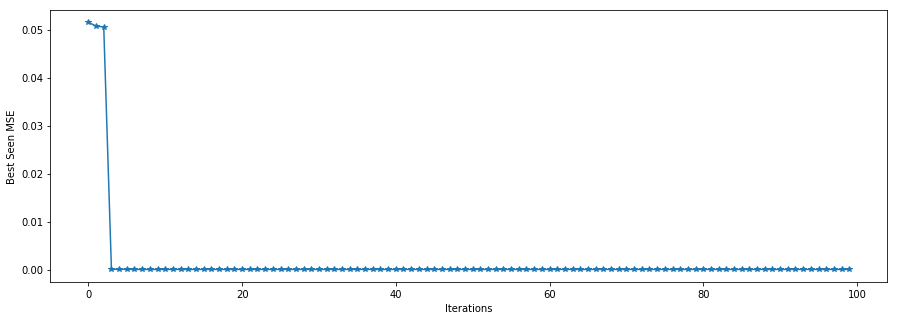

In [0]:
best_model = torch.load(path + "models/best_model_cnn_stator")
results = pd.read_csv(path + "results/AutoML_CNN_stator.csv")
results = results[results["Status"]=="COMPLETED"]

plt.figure(figsize=(15,5))
best, = plt.plot(np.minimum.accumulate(np.array(results.Objective)),'*-')
#actual, = plt.plot(np.array(results.Objective),'*-')

#plt.legend([actual, best],
#           ['Calculated','Best Seen']) 

plt.xlabel('Iterations')
plt.ylabel('Best Seen MSE')
plt.show()

In [0]:
look_back  = 60

test_gen = dataloader([df.values for df in df_test], look_back, shuffle=False)
size = np.sum(df.shape[0] for df in df_test)

batch_size = 510

y_test = []
#y_pred_all = []
for x in range(0, size, batch_size):
    X_test = []
    for i in range(batch_size):
        try:
            X,y = next(test_gen)
            X_test.append(X)
            y_test.append(y)
        except:
            break

    inpt = np.array(X_test).reshape(-1, look_back, 10)
    x_test_batch = torch.tensor(inpt,dtype=torch.float32).to(device)  
    y_pred = best_model(x_test_batch)
    if x==0:
        y_pred_all = y_pred.cpu().detach().numpy()
    else:
        y_pred_all = np.concatenate((y_pred_all,y_pred.cpu().detach().numpy()))

y_test = np.array(y_test).reshape(-1,3)

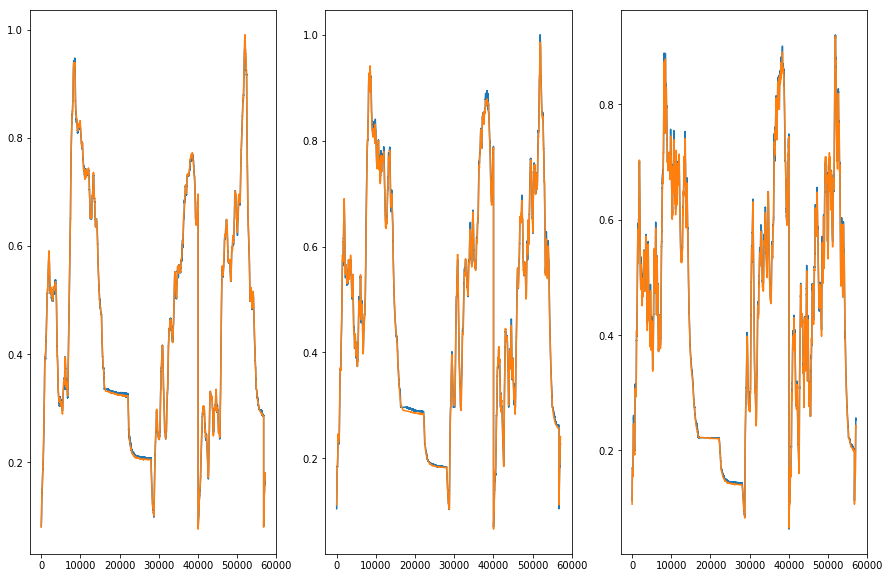

In [0]:
plt.figure(figsize=(15,10))

plt.subplot(131)
plt.plot(y_test[:,0])
plt.plot(y_pred_all[:,0])

plt.subplot(132)
plt.plot(y_test[:,1])
plt.plot(y_pred_all[:,1])

plt.subplot(133)
plt.plot(y_test[:,2])
plt.plot(y_pred_all[:,2])
plt.show()

In [0]:
np.mean(np.abs((y_test - y_pred_all)/np.abs(y_test))) #MAPE

0.010602141535072366